In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.nonparametric import CensoringDistributionEstimator
from sksurv.nonparametric import kaplan_meier_estimator
from itertools import combinations
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pickle
import yaml
from tqdm import tqdm

import sys
sys.path.append("../")
from models import DiscreteNAM, NAM
from utils import discretize, get_dataset, get_bin_counts, get_discetized_run_data_survival, get_run_data, get_ebm_run_data

sys.path.append("../run_scripts")
from epoch_functions import train_epoch_dys_pairs, test_epoch_dys_pairs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Function to get calibration data using kaplan meier estimates
# cdf_preds: predicted cdf values P(T <= t) at a specific evaluation time t
# y: survival label in sksurv format
# eval_time: evaluation time t
# n_bins: number of bins to divide the data into
def get_calibration_data_km(cdf_preds, y, eval_time, n_bins=20, method="quantile"):
    
    if method == "quantile":
        # Get bins from quantiles of predictions
        quantiles = np.quantile(
            cdf_preds,
            np.linspace(0, 1, n_bins+2)
        )
    elif method == "uniform":
        # Get bins from uniform spacing
        quantiles = np.linspace(cdf_preds.min(), cdf_preds.max(), n_bins+2)
    else:
        raise ValueError("method must be 'quantile' or 'uniform'")
    
    predicted = []
    observed = []
    
    print("Quantiles", quantiles)
    
    for bin_ in zip(quantiles[:-1], quantiles[1:]):
        
        if bin_[0] == 1:
            bin_data = cdf_preds[
                cdf_preds == 1
            ]
            bin_y = y[
                cdf_preds == 1
            ]
            
        else:
            bin_data = cdf_preds[
                np.logical_and(
                    cdf_preds >= bin_[0],
                    cdf_preds < bin_[1]
                )
            ]
            bin_y = y[
                np.logical_and(
                    cdf_preds >= bin_[0],
                    cdf_preds < bin_[1]
                )
            ]

        
        times, surv_prob = kaplan_meier_estimator(bin_y["event"], bin_y["time"])
        predicted.append(bin_data.mean())
        observed.append(
            1 - surv_prob[np.clip(
                np.searchsorted(times, eval_time), 0, len(times)-1
            )]
        )
        
        
    return np.array(predicted), np.array(observed), quantiles

In [5]:
def get_preds_discrete_nam_(dataset, seed, split, use_feature_set=False):
    
    # Read in model
    model = torch.load(f"../model_saves/discrete_nam_survival_{dataset}_seed{seed}_split{split}.pt").to(device)
    
    # Read in args using yaml
    args_id = model.params_id
    with open(f"../run_parameters/discrete_nam_survival_{dataset}_seed{seed}_split{split}_params{args_id}.yaml", "r") as f:
        args = yaml.safe_load(f)
    
    
    data_dict = \
        get_discetized_run_data_survival(dataset, seed=seed, split=split, max_bins=args["max_bins"], use_feature_set=use_feature_set)
        
        
    if use_feature_set:
        selected_feats = data_dict["selected_feats"]
        selected_pairs = data_dict["selected_pairs"]
        
        X_test_discrete = data_dict["X_test_discrete"].iloc[:, selected_feats]
        X_test_interactions = data_dict["X_test_discrete"].values[:, selected_pairs]
    else:
        X_test_discrete = data_dict["X_test_discrete"]
        
        active_feats = model.active_feats.cpu().numpy()
        selected_pairs = list(combinations(active_feats, 2))
        
        X_test_interactions = X_test_discrete.values[:, selected_pairs]

    batch_size = args["batch_size"]

    test_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_test_discrete.values),
        torch.FloatTensor(X_test_interactions), 
        torch.BoolTensor(data_dict["y_test"]["event"]),
        torch.FloatTensor(data_dict["y_test"]["time"].copy()),
        torch.FloatTensor(data_dict["pcw_obs_times_test"])
    )
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    eval_times = data_dict["eval_times"].to(device)
    pcw_eval_times = data_dict["pcw_eval_times"].to(device)

    _, preds = test_epoch_dys_pairs(model, test_loader, eval_times, pcw_eval_times, model_mains=model)
    
    return preds, data_dict["y_train"], data_dict["y_val"], data_dict["y_test"], eval_times.cpu().numpy()

In [6]:
def get_calibration_data_discrete_nam(dataset, seed, eval_time, use_feature_set=False):
    splits = [1, 2, 3, 4, 5]
    # splits = [1]
    
    split_preds = 0
    for split in splits:
        preds, y_train, y_val, y_test, eval_times = get_preds_discrete_nam_(dataset, seed, split, use_feature_set)
        split_preds += preds
    
    cdf_preds = torch.sigmoid(split_preds / len(splits)).cpu().numpy()
    
    pred_index = np.searchsorted(eval_times, eval_time)
    cdf_preds = cdf_preds[:, pred_index]
    
    return get_calibration_data_km(cdf_preds, y_test, eval_time)

In [7]:
def predict_all_cum_hazard_(ebm, x, times, monte_carlo=True):
    x_input = pd.DataFrame(
        np.tile(x.values.reshape(-1, 1), len(times)).T,
        columns=list(x.index)
    )
    x_input["time"] = times
    
    preds = ebm.predict_proba(x_input)[:, 1]

    if monte_carlo:
        return pd.Series(
            times * np.cumsum(preds) / np.arange(1, len(preds)+1)
        )
    else:
        return pd.Series(np.cumsum(preds))

In [8]:
def get_calibration_data_ebm(dataset, seed, eval_time, use_feature_set=False, n_bins=20):
    
    with open(f"../model_saves/ebm_{dataset}_seed{seed}.pkl", "rb") as f:
        ebm = pickle.load(f)
        
    data_dict = get_ebm_run_data(dataset, seed)
    X_test = data_dict["X_test"]
    y_train = data_dict["y_train"]
    y_test = data_dict["y_test"]
    
    if use_feature_set:
        # Save selected_features to yaml
        with open(f"../feature_sets/coxnet_{dataset}_seed{seed}.yaml", "r") as f:
            selected_features = yaml.safe_load(f)
        
        # selected_features = ebm.feature_names_in_
        
        X_test = X_test[selected_features]
        
    # pred_times = np.linspace(
    #     max(y_train["time"].min(), y_test[y_test["event"]]["time"].min()) + 1e-4,
    #     min(y_train["time"].max(), y_test[y_test["event"]]["time"].max()) - 1e-4,
    #     1000
    # )
    
    times = np.unique(y_test[(y_test["event"]) & (y_test["time"] <= eval_time)]["time"])

    tqdm.pandas()
    cum_hazards = X_test.progress_apply(
        lambda row: predict_all_cum_hazard_(ebm, row, times, monte_carlo=False), 
        axis=1
    ).values
    
    surv_preds = np.exp(-cum_hazards)
    
    # Get the last value which is the surv pred at the eval time
    cdf_preds = 1 - surv_preds[:, -1]
    
    return get_calibration_data_km(cdf_preds, y_test, eval_time, n_bins=n_bins)

In [14]:
X, y = get_dataset("unos")
pd.Series(y["time"]).describe()

count    474349.000000
mean        693.844238
std         682.046082
min           1.000000
25%         161.000000
50%         477.000000
75%        1035.000000
max        4110.000000
dtype: float64

In [9]:
unos_dnam_data = get_calibration_data_discrete_nam("unos", 10, 365*5, use_feature_set=False)

Quantiles [0.03499084 0.35883821 0.4369489  0.48803545 0.53254718 0.56517154
 0.59787232 0.62367016 0.64983875 0.67595005 0.6997425  0.7219286
 0.74161923 0.76446646 0.78631258 0.81074752 0.83766329 0.86884254
 0.90384695 0.96042055 0.98040158 0.99961638]


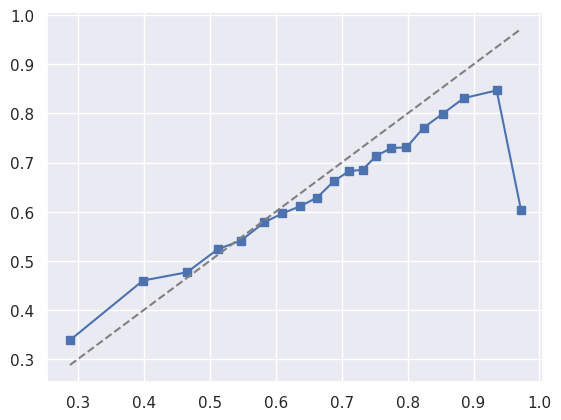

In [28]:
predicted, observed, _ = dnam_data

predicted = np.array(predicted)
observed = np.array(observed)

plt.plot(predicted[:-1], observed[:-1], "s-")
plt.plot([predicted[:-1].min(), predicted[:-1].max()], [predicted[:-1].min(), predicted[:-1].max()], "--", color="gray")

In [10]:
support_dnam_data = get_calibration_data_discrete_nam("support", 10, 365*5, use_feature_set=False)

Quantiles [0.15501067 0.3737351  0.47335832 0.54021513 0.59545654 0.63879232
 0.67896873 0.71944149 0.74930245 0.78060824 0.81400774 0.83289991
 0.85079247 0.8715418  0.88921928 0.90444112 0.92164465 0.93639737
 0.95059139 0.96563216 0.98002581 0.99893016]


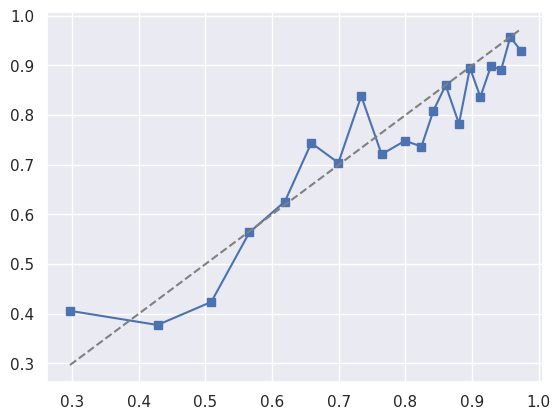

In [10]:
predicted, observed, _ = dnam_data

predicted = np.array(predicted)
observed = np.array(observed)

plt.plot(predicted[:-1], observed[:-1], "s-")
plt.plot([predicted[:-1].min(), predicted[:-1].max()], [predicted[:-1].min(), predicted[:-1].max()], "--", color="gray")

In [11]:
support_ebm_data = get_calibration_data_ebm("support", seed=10, eval_time=365*5, use_feature_set=False, n_bins=20)

  0%|          | 0/1821 [00:00<?, ?it/s]

100%|██████████| 1821/1821 [00:42<00:00, 42.64it/s]

Quantiles [0.5625502  0.90040637 0.95308645 0.9729013  0.98401006 0.99054371
 0.99427815 0.99670477 0.99826309 0.99917295 0.99967333 0.99988315
 0.99996435 0.99999236 0.99999887 0.99999987 1.         1.
 1.         1.         1.         1.        ]


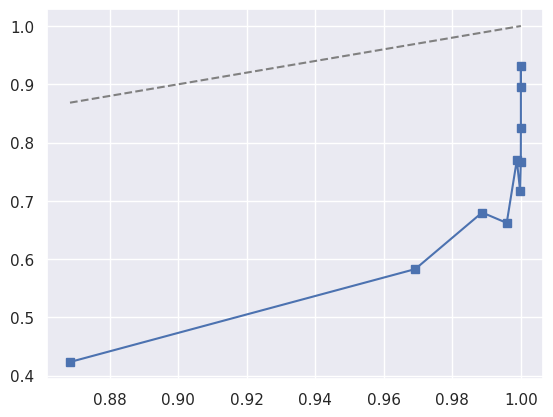

In [26]:
predicted, observed, _ = ebm_data

predicted = np.array(predicted)
observed = np.array(observed)

plt.plot(predicted[:-1], observed[:-1], "s-")
plt.plot([predicted[:-1].min(), predicted[:-1].max()], [predicted[:-1].min(), predicted[:-1].max()], "--", color="gray")

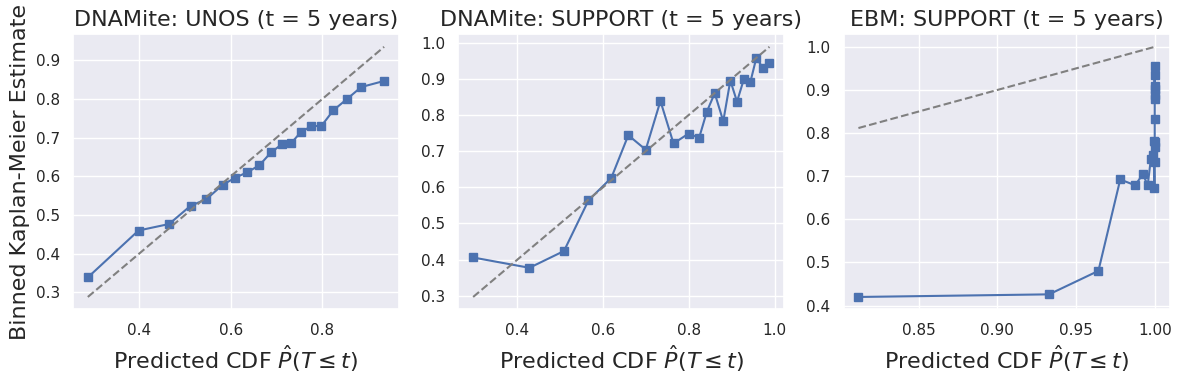

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

predicted, observed, _ = unos_dnam_data
axes[0].plot(predicted[:-2], observed[:-2], "s-")
axes[0].plot([predicted[:-2].min(), predicted[:-2].max()], [predicted[:-2].min(), predicted[:-2].max()], "--", color="gray")
axes[0].set_title("DNAMite: UNOS (t = 5 years)", fontsize=16)
axes[0].set_xlabel(r"Predicted CDF $\hat{P}(T \leq t)$", fontsize=16)
axes[0].set_ylabel("Binned Kaplan-Meier Estimate", fontsize=16)

predicted, observed, _ = support_dnam_data
axes[1].plot(predicted, observed, "s-")
axes[1].plot([predicted.min(), predicted.max()], [predicted.min(), predicted.max()], "--", color="gray")
axes[1].set_title("DNAMite: SUPPORT (t = 5 years)", fontsize=16)
axes[1].set_xlabel(r"Predicted CDF $\hat{P}(T \leq t)$", fontsize=16)

predicted, observed, _ = support_ebm_data
axes[2].plot(predicted, observed, "s-")
axes[2].plot([predicted.min(), predicted.max()], [predicted.min(), predicted.max()], "--", color="gray")
axes[2].set_title("EBM: SUPPORT (t = 5 years)", fontsize=16)
axes[2].set_xlabel(r"Predicted CDF $\hat{P}(T \leq t)$", fontsize=16)

plt.tight_layout()
plt.savefig("figures/extra_calibration_plots.pdf")

In [7]:
dnam_data = get_calibration_data_discrete_nam("heart_failure_survival", 10, 365*5, use_feature_set=True)

Number of categorical features 3


Number of categorical features 3


Number of categorical features 3


Number of categorical features 3


Number of categorical features 3


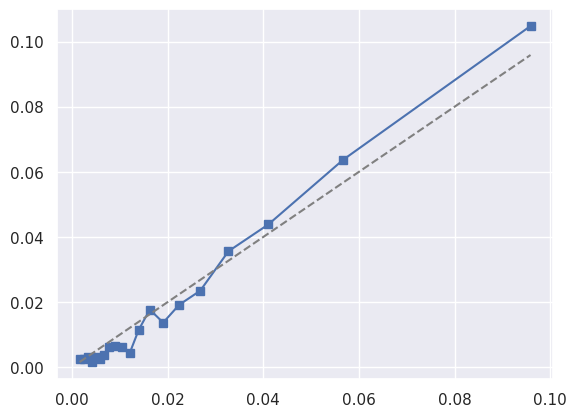

In [9]:
predicted, observed, _ = dnam_data

predicted = np.array(predicted)
observed = np.array(observed)

plt.plot(predicted[:-1], observed[:-1], "s-")
plt.plot([predicted[:-1].min(), predicted[:-1].max()], [predicted[:-1].min(), predicted[:-1].max()], "--", color="gray")

In [11]:
ebm_data = get_calibration_data_ebm("heart_failure_survival", seed=10, eval_time=365*5, use_feature_set=True)

100%|██████████| 53164/53164 [04:53<00:00, 181.05it/s]


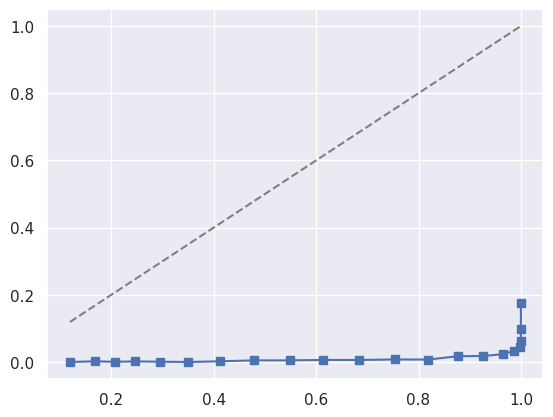

In [15]:
predicted, observed, _ = ebm_data

predicted = np.array(predicted)
observed = np.array(observed)

plt.plot(predicted, observed, "s-")
plt.plot([predicted.min(), predicted.max()], [predicted.min(), predicted.max()], "--", color="gray")

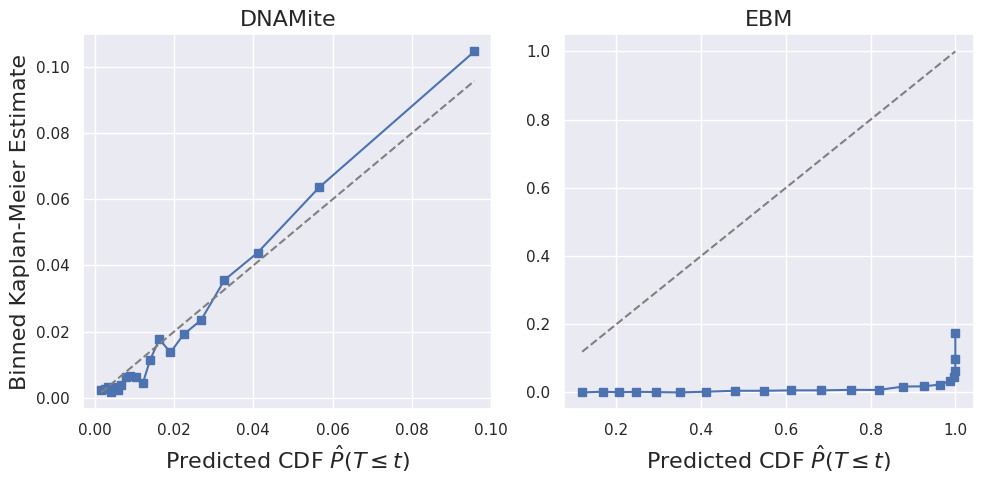

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

predicted, observed, _ = dnam_data

predicted = np.array(predicted)
observed = np.array(observed)

ax[0].plot(predicted[:-1], observed[:-1], "s-")
ax[0].plot([predicted[:-1].min(), predicted[:-1].max()], [predicted[:-1].min(), predicted[:-1].max()], "--", color="gray")
ax[0].set_title("DNAMite", fontsize=16)
ax[0].set_xlabel(r"Predicted CDF $\hat{P}(T \leq t)$", fontsize=16)
ax[0].set_ylabel("Binned Kaplan-Meier Estimate", fontsize=16)

predicted, observed, _ = ebm_data

predicted = np.array(predicted)
observed = np.array(observed)

ax[1].plot(predicted, observed, "s-")
ax[1].plot([predicted.min(), predicted.max()], [predicted.min(), predicted.max()], "--", color="gray")
ax[1].set_title("EBM", fontsize=16)
ax[1].set_xlabel(r"Predicted CDF $\hat{P}(T \leq t)$", fontsize=16)
# ax[1].set_ylabel("Binned Kaplan-Meier Estimate")

plt.tight_layout()
plt.savefig("figures/calibration_plots.pdf")

In [9]:
dataset = "heart_failure_survival"
seed = 10
split = 1
use_feature_set = True

data_dict = get_discetized_run_data_survival(dataset, seed=seed, split=split, max_bins=32, use_feature_set=use_feature_set)

Number of categorical features 3


In [15]:
data_dict["X_test_discrete"].columns[data_dict["selected_feats"]].shape

(29,)